In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset
from functions.make_plots import *
from functions.pruning_methods import *

/Users/sixteoriolllenassegura/prune_llm/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_model():
    model = AutoModelForSequenceClassification.from_pretrained("model")
    return model


def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding=True)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    tp = np.sum(np.logical_and(preds, labels))
    tn = np.sum(np.logical_and(preds == 0, labels == 0))
    fp = np.sum(np.logical_and(preds, labels == 0))
    fn = np.sum(np.logical_and(preds == 0, labels))
    acc = np.sum(labels == preds) / len(labels)
    precision = 0 if tp + fp == 0 else tp / (tp + fp)
    recall = 0 if tp + fn == 0 else tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "matthews": mcc,
    }


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
dataset = load_dataset("glue", "cola")
tokenized_dataset = dataset.map(preprocess_function, batched=True)["validation"]

training_args = TrainingArguments(
    per_device_eval_batch_size=100,
    output_dir="./results",
)


In [9]:
model = load_model().to('mps')

# Evaluate modified model and save result
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)

trainer.evaluate(tokenized_dataset)


100%|██████████| 11/11 [00:02<00:00,  4.18it/s]


{'eval_loss': 0.8195775151252747,
 'eval_accuracy': 0.8092042186001918,
 'eval_precision': 0.8246268656716418,
 'eval_recall': 0.9195561719833565,
 'eval_f1': 0.8695081967213115,
 'eval_matthews': 0.5294395294021531,
 'eval_runtime': 2.9199,
 'eval_samples_per_second': 357.207,
 'eval_steps_per_second': 3.767}

In [ ]:
print_weight_matrices(model.cpu(), ignore_zeros=True, visualization_mode='abs')

In [ ]:
## USING AREAS

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

fig, axs = plt.subplots(2, 3, figsize=(15, 9))
values = np.arange(0, 0.4, 0.005)
values_100 = 100 * values

for block_size in [8, 16, 32, 64]:
  eval_results = []
  for area in values:
    # Load model
    model = load_model()

    # Modify model
    for x in model.state_dict().keys():
      tensor = model.state_dict()[x]
      if ".layer." in x and len(tensor.size()) == 2:
        randomly_prune_blocks_by_area(tensor, area, block_size)

    # Evaluate modified model and save result
    trainer = Trainer(
      model=model,
      args = training_args,
      compute_metrics=compute_metrics,
    )
    eval_results.append(trainer.evaluate(tokenized_dataset))

  eval_loss = [x['eval_loss'] for x in eval_results]
  eval_accuracy = [x['eval_accuracy'] for x in eval_results]
  eval_precision = [x['eval_precision'] for x in eval_results]
  eval_recall = [x['eval_recall'] for x in eval_results]
  eval_f1 = [x['eval_f1'] for x in eval_results]
  eval_matthews = [x['eval_matthews'] for x in eval_results]

  axs[0, 0].plot(values_100, eval_loss, label = f"Block size {block_size}")
  axs[0, 1].plot(values_100, eval_accuracy, label = f"Block size {block_size}")
  axs[0, 2].plot(values_100, eval_precision, label = f"Block size {block_size}")
  axs[1, 0].plot(values_100, eval_recall, label = f"Block size {block_size}")
  axs[1, 1].plot(values_100, eval_f1, label = f"Block size {block_size}")
  axs[1, 2].plot(values_100, eval_matthews, label = f"Block size {block_size}")

axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('% of pruned area')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('% of pruned area')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

axs[0, 2].set_title('Precision')
axs[0, 2].set_xlabel('% of pruned area')
axs[0, 2].set_ylabel('Precision')
axs[0, 2].legend()

axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('% of pruned area')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

axs[1, 1].set_title('F1 Score')
axs[1, 1].set_xlabel('% of pruned area')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend()

axs[1, 2].set_title('Matthews Correlation')
axs[1, 2].set_xlabel('% of pruned area')
axs[1, 2].set_ylabel('Matthews Correlation')
axs[1, 2].legend()

plt.tight_layout()
plt.show()

In [ ]:
print_weight_matrices(model.cpu(), ignore_zeros=True, visualization_mode='abs')

In [ ]:
print(eval_results[1])

{'eval_loss': 1.1758610010147095, 'eval_accuracy': 0.5445829338446788, 'eval_f1': 0.5383867832847424, 'eval_precision': 0.8993506493506493, 'eval_recall': 0.3841886269070735, 'eval_matthews': 0.2915689932969142, 'eval_runtime': 1.0908, 'eval_samples_per_second': 956.205, 'eval_steps_per_second': 10.085}


In [38]:
print(model.state_dict().keys())

odict_keys(['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.output_layer_norm.

100%|██████████| 11/11 [00:02<00:00,  3.80it/s]


{'eval_loss': 0.8195775151252747, 'eval_accuracy': 0.8092042186001918, 'eval_precision': 0.8246268656716418, 'eval_recall': 0.9195561719833565, 'eval_f1': 0.8695081967213115, 'eval_matthews': 0.5294395294021531, 'eval_runtime': 3.2775, 'eval_samples_per_second': 318.23, 'eval_steps_per_second': 3.356}
Min: -0.7052584886550903 Max: 0.4977506995201111
Mean: 6.26941691734828e-05 Std: 0.04336584359407425 Median: 0.00014426009147427976


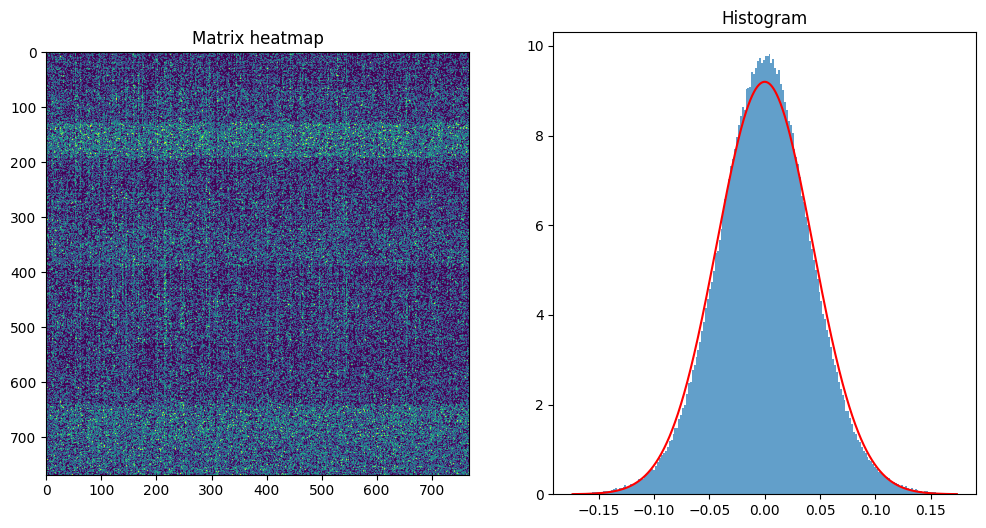

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

model = load_model()

# Evaluate modified model and save result
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)

tensor = model.state_dict()['distilbert.transformer.layer.0.attention.q_lin.weight']
#randomly_prune_blocks_by_area(tensor, area_percentage=0.3, block_size=128)
print(trainer.evaluate(tokenized_dataset))
plot_matrix_analysis(tensor.cpu().detach().numpy(), visualization_mode='abs', show_gaussian=True, ignore_zeros=True)

In [129]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from functions.make_plots import *
from functions.pruning_methods import *

area_percentage = 0.3
block_size = 128
aux = np.zeros([6,6])
repetitions = 100

evaluations = []
for i in range(repetitions):
    model = load_model()
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
    )

    tensor = model.state_dict()['distilbert.transformer.layer.0.attention.q_lin.weight']

    output = randomly_prune_blocks_by_area(tensor, area_percentage, block_size, verbose=True)
    evaluation = trainer.evaluate(tokenized_dataset)
    evaluation['grid_size'] = output['grid_size']
    evaluation['pairs'] = output['pairs']
    evaluations.append(evaluation)

100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


In [134]:
import GPUtil
print(GPUtil.getAvailable()) # Returns a list of available GPUs. Will be empty of no GPU is available
print(GPUtil.showUtilization())

[]
| ID | GPU | MEM |
------------------
None


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [130]:
import pandas as pd

df = pd.DataFrame(evaluations)
print(df)

   eval_loss  eval_accuracy  eval_precision  eval_recall   eval_f1  \
0   0.812877       0.806328        0.823970     0.915395  0.867280   
1   0.816123       0.810163        0.828105     0.915395  0.869565   
2   0.816904       0.809204        0.827889     0.914008  0.868820   

   eval_matthews  eval_runtime  eval_samples_per_second  \
0       0.522578        6.3962                  163.066   
1       0.533129        6.4739                  161.109   
2       0.530876        7.0044                  148.907   

   eval_steps_per_second                                              pairs  
0                  1.720  {(4, 0), (0, 0), (4, 3), (3, 1), (1, 4), (4, 5...  
1                  1.699  {(1, 2), (2, 1), (1, 5), (0, 3), (5, 1), (3, 0...  
2                  1.570  {(1, 2), (5, 5), (1, 5), (4, 3), (2, 0), (5, 1...  


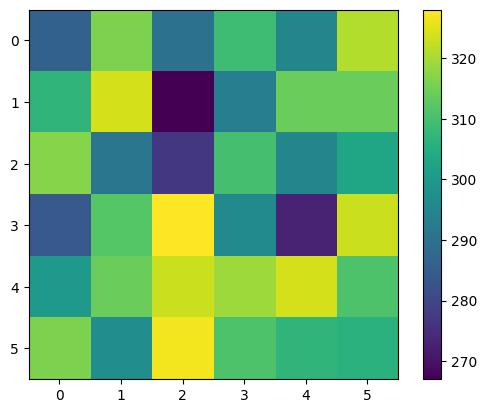

In [119]:
plt.imshow(aux)
plt.colorbar()
plt.show()

In [29]:
a = torch.randn((10000, 10000), device='cpu')
b = torch.randn((10000, 10000), device='cpu')

In [30]:

# Start the timer
start_time = time.time()

# Perform element-wise multiplication and then calculate the product
c = torch.matmul(a, b)

# End the timer
end_time = time.time()

# Print the result and the time taken
print("Result:", c)
print("Time taken:", end_time - start_time, "seconds")

Result: tensor([[ -33.4347, -129.5229,  110.6746,  ...,    6.7729,  -90.1087,
          -47.5483],
        [   0.6149, -111.1391,  -84.3079,  ...,  -52.4938,   42.6120,
         -158.1987],
        [   1.8025,  -96.9060,  139.2102,  ..., -121.9789,   -1.9131,
           -2.5484],
        ...,
        [ -15.9135,   86.6879,  -63.5111,  ...,  180.3797,    0.6262,
          -83.8994],
        [  93.5401,  -57.5067,   69.0546,  ...,  -94.2723,  -41.0372,
          128.0915],
        [ -26.6218,   28.5765, -178.8486,  ...,  105.9166,   33.2438,
          -20.6748]])
Time taken: 2.3349790573120117 seconds


In [53]:
import pandas as pd
df = pd.read_csv("/Users/sixteoriolllenassegura/prune_llm/outputs/output_a0.1_bs128.csv")
df.sample()

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_matthews,eval_runtime,eval_samples_per_second,eval_steps_per_second,area_percentage,block_size,grid_size,pairs,layer
398,0.824331,0.805369,0.820545,0.919556,0.867233,0.518867,2.8589,364.829,3.848,0.1,128,"(6,6)","{(1,1),(4,1),(2,1),(3,0,)}",distilbert.transformer.layer.0.attention.q_lin...
